# Preprocessor

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pickle

import re
import emoji
import numpy as np
from nltk.tokenize.casual import EMOTICON_RE

from tqdm import tqdm
#nltk.download('wordnet')
#nltk.download('words')
from nltk.sentiment.util import mark_negation
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

from collections import Counter
from wordcloud import WordCloud
from nltk import FreqDist
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

DATASET_COLUMNS = ['Id', 'Review', 'Sentiment']
senti_labels = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
senti_categories = list(senti_labels.values())
NUM_of_CLASSES = 3


processed_folder_path = "./pls/Thesis_Jupyter_Final/src/processed"

cleaned_data_filename = "cleaned_data.csv"
vocab_filename = 'vocab.txt'



input_folder_path = "./pls/Thesis_Jupyter_Final/src/input/"
data_filename = "reviews_data.csv"
emojis = [
    # HAPPY
    ":-)", ":)", ";)", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)",
    "=)", ":}", ":^)", ":-D", ":D", "8-D", "8D", "x-D", "xD", "X-D",
    "XD", "=-D", "=D", "=-3", "=3", ":-))", ":'-)", ":')", ":*", ":^*",
    ">:P", ":-P", ":P", "X-P", "x-p", "xp", "XP", ":-p", ":p", "=p",
    ":-b", ":b", ">:)", ">;)", ">:-)", "<3",

    # SAD
    ":L", ":-/", ">:/", ":S", ">:[", ":@", ":-(", ":[", ":-||", "=L", 
    ":<", ":-[", ":-<", "=\\", "=/", ">:(", ":(", ">.<", ":'-(", ":'(",
    ":\\", ":-c", ":c", ":{", ">:\\", ";("
]


Goal of project: 

This notebook includes: (steps)

# Load Data

First, we load and explore the dataset and apply some initial processing such as setting the '*Id*' column as index and removing any empty rows.

In [97]:
def drop_missing(data):
    # Remove any rows with missing values and reset the index
    data.replace('', np.nan, inplace=True)
    data = data.dropna()
    data.reset_index(drop=True, inplace=True)
    return data

In [98]:
def load_data():
    # Load data
    data_file_path = os.path.join(input_folder_path, data_filename)
    df_raw = pd.read_csv(data_file_path)

    # Set ID as index
    df_raw.set_index('Id', inplace=True, drop=True)
    df_raw = drop_missing(df_raw)

    print(df_raw.info())
    print(f'\nDataset shape: {df_raw.shape}\n')

    return df_raw


df_original = load_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Review     107018 non-null  object
 1   Sentiment  107018 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
None

Dataset shape: (107018, 2)



In [99]:
df_original.head(20)

,Review,Sentiment
0,good and interesting,3
1,This class is very helpful...,3
2,like!Prof and TAs are help...,3
3,Easy to follow and include...,3
4,Really nice teacher!I coul...,3
5,Great course - I recommend...,3
6,One of the most useful cou...,3
7,I was disappointed because...,2
8,Super content. I'll defini...,3
9,One of the excellent cours...,3


### Analysing Data (TODO)
We then analyse the dataset by observing the distribution of review per sentiment.

In [100]:
def print_senti_counts(counts):
    # Print the number of reviews per sentiment 
    for senti, count in counts.items():
        sentiment_name = senti_labels[senti]
        print(f"{senti} ({sentiment_name}): {count} reviews")

def plot_senti_counts(counts):
    # Plot counts per sentiment
    colors = ['limegreen', 'dodgerblue', 'red']
    plt.pie(counts, colors=colors, autopct='%1.1f%%',  pctdistance=0.8, textprops={'fontsize': 10, 'color': 'black'}, startangle=90)
    plt.axis('equal')  # pie as a circle
    plt.legend(labels=senti_categories[::-1], loc='lower left')
    plt.title('Distribution of Reviews per Sentiment')
    plt.show()

def count_words(text):
    # Count words per review
    return len(str(text).split(' '))

3 (Positive): 97227 reviews
2 (Neutral): 5071 reviews
1 (Negative): 4720 reviews


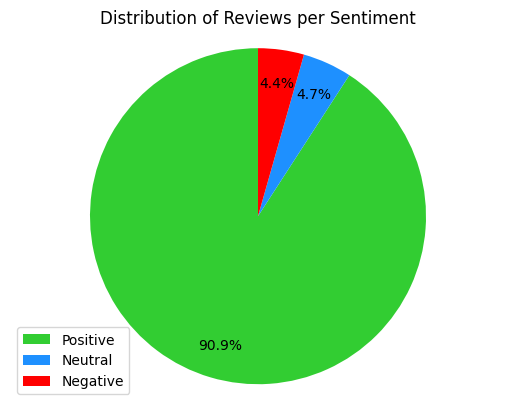

Total word count:  2661665
Average review length: 24.87


In [110]:
def analyse_data(df):
    # Call all the data analysis functions at once
    senti_counts = df['Sentiment'].value_counts()
    print_senti_counts(senti_counts)
    plot_senti_counts(senti_counts)

    # Calculate total and average word count without adding a new column to the dataframe
    total_word_count = df['Review'].apply(count_words).sum()
    avg_review_len = df['Review'].apply(count_words).mean()

    print("Total word count: ", total_word_count)
    print(f"Average review length: {avg_review_len:.2f}")


analyse_data(df_original)

In [120]:
# Create a copy of the original DataFrame to preserve the original data
df_clean = df_original.copy()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None) 

In [121]:
def clean_data(df):
    # 1) Lowercase
    df['Review'] = df['Review'].str.lower()

    # 2) Replace contractions with their standard full forms
    contraction_mapping = {
            "isn't": "is not",
            "aren't": "are not",
            "don't": "do not",
            "doesn't": "does not",
            "wasn't": "was not",
            "weren't": "were not",
            "didn't": "did not",
            "haven't": "have not",
            "hasn't": "has not",
            "hadn't": "had not",
            "won't": "will not",
            "can't": "cannot",
            "couldn't": "could not",
            "shouldn't": "should not",
            "wouldn't": "would not",
            "mightn't": "might not",
            "mustn't": "must not",
            }

    for contraction, standard in contraction_mapping.items():
        df['Review'] = df['Review'].str.replace(contraction, standard)

    
    # 3) Remove punctuation in between words e.g. "course.sometimes", "i'll" and replace with space
    pattern = r'(?<=\w)[^\w\s]+(?=\w)'
    df['Review'] = df['Review'].str.replace(pattern, ' ')

    # 4) Tokenize text into individual words (removes all extra spaces \s)
    tokenizer = TweetTokenizer()
    df['Review'] = df['Review'].apply(tokenizer.tokenize)

    # 5) Remove punctuation first in between words (typo), and then all punctuation and numerals except for tokenized emojis
    pattern = r"[^\w\s" + "".join(re.escape(e) for e in emojis + list(emoji.EMOJI_DATA.keys())) + "]|[\d]+" # match non-emoji special characters
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if not re.match(pattern, token)])

    # 6) Remove single characters
    df['Review'] = df['Review'].apply(lambda tokens: [word for word in tokens if len(word) > 1])

    # 8) Perform negation tagging
    df['Review'] = df['Review'].apply(mark_negation)

    # 9) Remove stopwords --> also removes words like 'not'
    stop_words = set(stopwords.words('english'))
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token.split('_')[0] not in stop_words])

     # 10) Lemmatize words using WordNetLemmatizer (also lemmatizes words removing _NEG)
    def lemmatize_token(token):
        lemmatizer = WordNetLemmatizer()
        if "_NEG" in token:
            word, tag = token.split("_NEG")
            return lemmatizer.lemmatize(word) + "_NEG"
        else:
            return lemmatizer.lemmatize(token)

    df['Review'] = df['Review'].apply(lambda tokens: [lemmatize_token(token) for token in tokens])

    # Convert preprocessed tokens back to string
    df['Review'] = df['Review'].apply(' '.join)

    return df

clean_data(df_clean)

/tmp/ipykernel_2722236/4143840565.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Review'] = df['Review'].str.replace(pattern, ' ')


In [ ]:
df_clean.head(20)

,Review,Sentiment
0,good interesting,3
1,class helpful currently st...,3
2,like prof ta helpful discu...,3
3,easy follow includes lot b...,3
4,really nice teacher could ...,3
5,great course recommend esp...,3
6,one useful course management,3
7,disappointed name misleadi...,2
8,super content definitely c...,3
9,one excellent course cours...,3


## Clean Text

Next, we clean the data applying the following techniques (TODO: add info):

In [114]:
# Text Cleaning
#english_words = set(nltk.corpus.words.words())
emojis = [
        #HAPPY
        ":-)",
        ":)",
        ";)",
        ":o)",
        ":]",
        ":3",
        ":c)",
        ":>",
        "=]",
        "8)",
        "=)",
        ":}",
        ":^)",
        ":-D",
        ":D",
        "8-D",
        "8D",
        "x-D",
        "xD",
        "X-D",
        "XD",
        "=-D",
        "=D",
        "=-3",
        "=3",
        ":-))",
        ":'-)",
        ":')",
        ":*",
        ":^*",
        ">:P",
        ":-P",
        ":P",
        "X-P",
        "x-p",
        "xp",
        "XP",
        ":-p",
        ":p",
        "=p",
        ":-b",
        ":b",
        ">:)",
        ">;)",
        ">:-)",
        "<3",
        # SAD
        ":L",
        ":-/",
        ">:/",
        ":S",
        ">:[",
        ":@",
        ":-(",
        ":[",
        ":-||",
        "=L",
        ":<",
        ":-[",
        ":-<",
        "=\\",
        "=/",
        ">:(",
        ":(",
        ">.<",
        ":'-(",
        ":'(",
        ":\\",
        ":-c",
        ":c",
        ":{",
        ">:\\",
        ";(",
    ]

In [115]:
# 1) Lowercase
df['Review'] = df['Review'].str.lower()
df.head()

,Review,Sentiment
0,good and interesting,3
1,this class is very helpful...,3
2,like!prof and tas are help...,3
3,easy to follow and include...,3
4,really nice teacher!i coul...,3


In [116]:
# 2) Replace contractions with their standard full forms
contraction_mapping = {
        "isn't": "is not",
        "aren't": "are not",
        "don't": "do not",
        "doesn't": "does not",
        "wasn't": "was not",
        "weren't": "were not",
        "didn't": "did not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not",
        "won't": "will not",
        "can't": "cannot",
        "couldn't": "could not",
        "shouldn't": "should not",
        "wouldn't": "would not",
        "mightn't": "might not",
        "mustn't": "must not",
        }

for contraction, standard in contraction_mapping.items():
    df['Review'] = df['Review'].str.replace(contraction, standard)

print(df)

                               Review  Sentiment
0                good and interesting          3
1       this class is very helpful...          3
2       like!prof and tas are help...          3
3       easy to follow and include...          3
4       really nice teacher!i coul...          3
...                               ...        ...
107013  trendy topic with talks fr...          3
107014  wonderful! simple and clea...          3
107015  an interesting and fun cou...          3
107016  very broad perspective, up...          3
107017  an informative course on t...          3

[107018 rows x 2 columns]


In [107]:
# 3) Remove punctuation in between words e.g. "course.sometimes", "i'll" and replace with space
pattern = r'(?<=\w)[^\w\s]+(?=\w)'
df['Review'] = df['Review'].str.replace(pattern, ' ')
print(df)

/tmp/ipykernel_2722236/1580789109.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Review'] = df['Review'].str.replace(pattern, ' ')


                               Review  Sentiment
0                good and interesting          3
1       this class is very helpful...          3
2       like prof and tas are help...          3
3       easy to follow and include...          3
4       really nice teacher i coul...          3
...                               ...        ...
107013  trendy topic with talks fr...          3
107014  wonderful! simple and clea...          3
107015  an interesting and fun cou...          3
107016  very broad perspective, up...          3
107017  an informative course on t...          3

[107018 rows x 2 columns]


In [108]:
# 4) Tokenize text into individual words (removes all extra spaces \s)
tokenizer = TweetTokenizer()
df['Review'] = df['Review'].apply(tokenizer.tokenize)
df.head()

,Review,Sentiment
0,"[good, and, interesting]",3
1,"[this, class, is, very, he...",3
2,"[like, prof, and, tas, are...",3
3,"[easy, to, follow, and, in...",3
4,"[really, nice, teacher, i,...",3


In [109]:
# 5) Remove punctuation first in between words (typo), and then all punctuation and numerals except for tokenized emojis
pattern = r"[^\w\s" + "".join(re.escape(e) for e in emojis + list(emoji.EMOJI_DATA.keys())) + "]|[\d]+" # match non-emoji special characters
df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if not re.match(pattern, token)])
print(df)

KeyboardInterrupt: 

In [ ]:
# 6) Remove single characters
df['Review'] = df['Review'].apply(lambda tokens: [word for word in tokens if len(word) > 1])
print(df)

                               Review  Sentiment
0            [good, and, interesting]          3
1       [this, class, is, very, he...          3
2       [like, prof, and, tas, are...          3
3       [easy, to, follow, and, in...          3
4       [really, nice, teacher, co...          3
...                               ...        ...
107013  [trendy, topic, with, talk...          3
107014  [wonderful, simple, and, c...          3
107015  [an, interesting, and, fun...          3
107016  [very, broad, perspective,...          3
107017  [an, informative, course, ...          3

[107018 rows x 2 columns]


In [ ]:
'''
# 7) Correct Spelling
# Note: also removes '...' that was not removed before
def correct_spelling(tokens):
    corrected_tokens = []
    for token in tokens:
        if token in emojis or token in emoji.EMOJI_DATA.keys():
            corrected_tokens.append(token)  # If token is an emoji, add it to the corrected tokens
        else:
            corrected_token = spell_checker.correction(token)
            if corrected_token is not None:
                corrected_tokens.append(corrected_token)
                
    return corrected_tokens

spell_checker = SpellChecker()
#df['Review'] = df['Review'].apply(lambda x: list(tqdm(correct_spelling(x), leave=False)))
# Apply correct_spelling function using tqdm
for i, row in tqdm(df.iterrows(), total=len(df)):
    df.at[i, 'Review'] = correct_spelling(row['Review'])
    print("Processed row:", i)
    
print(df)
'''

'\n# 7) Correct Spelling\n# Note: also removes \'...\' that was not removed before\ndef correct_spelling(tokens):\n    corrected_tokens = []\n    for token in tokens:\n        if token in emojis or token in emoji.EMOJI_DATA.keys():\n            corrected_tokens.append(token)  # If token is an emoji, add it to the corrected tokens\n        else:\n            corrected_token = spell_checker.correction(token)\n            if corrected_token is not None:\n                corrected_tokens.append(corrected_token)\n                \n    return corrected_tokens\n\nspell_checker = SpellChecker()\n#df[\'Review\'] = df[\'Review\'].apply(lambda x: list(tqdm(correct_spelling(x), leave=False)))\n# Apply correct_spelling function using tqdm\nfor i, row in tqdm(df.iterrows(), total=len(df)):\n    df.at[i, \'Review\'] = correct_spelling(row[\'Review\'])\n    print("Processed row:", i)\n    \nprint(df)\n'

In [ ]:
'''
# Correct Spelling
# Note: also removes '...' that was not removed before
def correct_spelling(tokens):
    corrected_tokens = []
    for token in tokens:
        if token in emojis or token in emoji.EMOJI_DATA.keys():
            corrected_tokens.append(token)  # If token is an emoji, add it to the corrected tokens
        else:
            corrected_token = spell_checker.correction(token)
            if corrected_token is not None:
                corrected_tokens.append(corrected_token)
                
    return corrected_tokens 

spell_checker = SpellChecker()

# Vectorizing the correct_spelling function 
vectorized_correct_spelling = np.vectorize(correct_spelling)

# Passing the dataframe column array into the vectorized function
df['Review'] = vectorized_correct_spelling(df['Review'].values)

print(df)
'''


"\n# Correct Spelling\n# Note: also removes '...' that was not removed before\ndef correct_spelling(tokens):\n    corrected_tokens = []\n    for token in tokens:\n        if token in emojis or token in emoji.EMOJI_DATA.keys():\n            corrected_tokens.append(token)  # If token is an emoji, add it to the corrected tokens\n        else:\n            corrected_token = spell_checker.correction(token)\n            if corrected_token is not None:\n                corrected_tokens.append(corrected_token)\n                \n    return corrected_tokens \n\nspell_checker = SpellChecker()\n\n# Vectorizing the correct_spelling function \nvectorized_correct_spelling = np.vectorize(correct_spelling)\n\n# Passing the dataframe column array into the vectorized function\ndf['Review'] = vectorized_correct_spelling(df['Review'].values)\n\nprint(df)\n"

In [ ]:
# TODO: note to self (to be added to word-doc): If you check token by token, it also removes english words

In [ ]:
# 8) Perform negation tagging
df['Review'] = df['Review'].apply(mark_negation)
print(df)

                               Review  Sentiment
0            [good, and, interesting]          3
1       [this, class, is, very, he...          3
2       [like, prof, and, tas, are...          3
3       [easy, to, follow, and, in...          3
4       [really, nice, teacher, co...          3
...                               ...        ...
107013  [trendy, topic, with, talk...          3
107014  [wonderful, simple, and, c...          3
107015  [an, interesting, and, fun...          3
107016  [very, broad, perspective,...          3
107017  [an, informative, course, ...          3

[107018 rows x 2 columns]


In [ ]:
# 9) Remove stopwords --> also removes words like 'not'
stop_words = set(stopwords.words('english'))
df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token.split('_')[0] not in stop_words])
print(df)

                               Review  Sentiment
0                 [good, interesting]          3
1       [class, helpful, currently...          3
2       [like, prof, tas, helpful,...          3
3       [easy, follow, includes, l...          3
4       [really, nice, teacher, co...          3
...                               ...        ...
107013  [trendy, topic, talks, exp...          3
107014  [wonderful, simple, clear,...          3
107015  [interesting, fun, course,...          3
107016  [broad, perspective, date,...          3
107017  [informative, course, soci...          3

[107018 rows x 2 columns]


In [ ]:
# 10) Lemmatize words using WordNetLemmatizer (also lemmatizes words removing _NEG)
def lemmatize_token(token):
    lemmatizer = WordNetLemmatizer()
    if "_NEG" in token:
        word, tag = token.split("_NEG")
        return lemmatizer.lemmatize(word) + "_NEG"
    else:
        return lemmatizer.lemmatize(token)

df['Review'] = df['Review'].apply(lambda tokens: [lemmatize_token(token) for token in tokens])
print(df)

                               Review  Sentiment
0                 [good, interesting]          3
1       [class, helpful, currently...          3
2       [like, prof, ta, helpful, ...          3
3       [easy, follow, includes, l...          3
4       [really, nice, teacher, co...          3
...                               ...        ...
107013  [trendy, topic, talk, expe...          3
107014  [wonderful, simple, clear,...          3
107015  [interesting, fun, course,...          3
107016  [broad, perspective, date,...          3
107017  [informative, course, soci...          3

[107018 rows x 2 columns]


In [ ]:
# Convert preprocessed tokens back to string
df['Review'] = df['Review'].apply(' '.join)
df.head()

,Review,Sentiment
0,good interesting,3
1,class helpful currently st...,3
2,like prof ta helpful discu...,3
3,easy follow includes lot b...,3
4,really nice teacher could ...,3


## Data Cleaning after Text Cleaning

In [ ]:
print(f'Shape before: {df_raw.shape}')
print(f'Shape after preprocessing, before removing empty rows: {df.shape}')

# Remove NaN rows, after cleaning text
df = drop_missing(df) 
print(f'Shape after preprocessing, after removing empty rows: {df.shape}\n')

Shape before: (107018, 2)
Shape after preprocessing, before removing empty rows: (107018, 2)
Shape after preprocessing, after removing empty rows: (106988, 2)



In [ ]:
data_file_path = os.path.join(input_folder_path, cleaned_data_filename)
df.to_csv(data_file_path, sep=',', index_label='Id')

# EDA Functions

In [ ]:
def make_wordcloud(word_counts):
    wordcloud = WordCloud().generate_from_frequencies(word_counts)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
def plot_word_freq_most_common(dataset, num_most_common=60):
    all_words = [word for review in dataset for word in review.split()]

    fdist = FreqDist(all_words)
    plt.figure(figsize=(12, 6))
    fdist.plot(num_most_common, title=f'Frequency Distribution of Most Common {num_most_common} Tokens')
    plt.show()

In [ ]:
def plot_word_freq_cdf(word_counts, max_count):
    counts = np.array(list(word_counts.values()))
    counts_sorted = np.sort(counts)[::-1] # descending

    # Calculate the cumulative sum of the sorted frequencies & normalize
    cumu_counts = np.cumsum(counts_sorted)
    cdf = cumu_counts / cumu_counts[-1]

    # Plot the CDF
    plt.figure(figsize=(12, 6))
    #plt.plot(counts_sorted, cdf)
    plt.plot(np.arange(1, len(cdf)+1), cdf)
    plt.xlabel('Word Rank')
    plt.ylabel('Cumulative Frequency')
    plt.title('CDF of Word Frequencies')
    #x_ticks = np.arange(0, max_count, 5000)
    #plt.xticks(x_ticks)
    plt.grid(True)
    plt.show()

    return counts_sorted

In [ ]:
def plot_word_freq_hist(word_counts):
    # Set up a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot word frequency distribution with linear scale
    ax1.hist(word_counts.values(), bins=range(1, 50), alpha=0.5)
    ax1.set_title('Word Frequency Distribution (Linear Scale)')
    ax1.set_xlabel('Word Frequency')
    ax1.set_ylabel('Number of Words')

    # Plot word frequency distribution with logarithmic scale
    ax2.hist(word_counts.values(), bins=range(1, 500, 10), alpha=0.5)
    ax2.set_yscale('log')
    ax2.set_title('Word Frequency Distribution (Logarithmic Scale)')
    ax2.set_xlabel('Word Frequency')
    ax2.set_ylabel('Number of Words')

In [ ]:
def calculate_word_statistics(word_counts):
    freqs = np.array(list(word_counts.values()))

    print("Mean frequency: ", np.mean(freqs))
    print("Median frequency: ", np.median(freqs))
    print("Max frequency: ", max(freqs))
    print("Min frequency: ", min(freqs))
    print("Standard deviation: ", np.std(freqs))
    print("1st quartile: ", np.percentile(freqs, 25))
    print("3rd quartile: ", np.percentile(freqs, 75))

# Preprocess Data

First we load cleaned data.

In [ ]:
data_file_path = os.path.join(input_folder_path, cleaned_data_filename)
df = pd.read_csv(data_file_path)

### Split train and test

In [ ]:
# Split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(df['Review'], df['Sentiment'], test_size=0.2, random_state=42)
# Split the training dataset further into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))
print(f"x_train: {x_train.head()}")

Data Distribution:
* train: 68472
* validation: 17118
* test: 21398

x_train: 73868    friendly beginner without ...
78926                good intro course
97646    great experience developed...
64107         clear enlightening thank
61156    detailed informing learned...
Name: Review, dtype: object


### Create & Analyse Vocabulary

In [ ]:
# Count words to create vocabulary
word_freqs = Counter()
for review in x_train:
    word_freqs.update(review.split())

word_freqs_len = len(word_freqs)

print(f"50 Most common words: {word_freqs.most_common(50)}")
print(f"Unfiltered vocab size: {word_freqs_len}")

50 Most common words: [('course', 50280), ('great', 15535), ('good', 12398), ('really', 7794), ('course_NEG', 7440), ('well', 6376), ('lot', 6260), ('learning', 6205), ('excellent', 5888), ('interesting', 5216), ('thank', 4776), ('learn', 4567), ('useful', 4075), ('would', 4041), ('much', 3952), ('easy', 3869), ('material', 3790), ('way', 3641), ('assignment', 3610), ('thanks', 3577), ('one', 3556), ('understand', 3419), ('like', 3411), ('basic', 3406), ('lecture', 3240), ('video', 3181), ('content', 3177), ('class', 3113), ('professor', 3081), ('best', 3009), ('concept', 3008), ('introduction', 2992), ('learned', 2972), ('time', 2866), ('teacher', 2865), ('helpful', 2790), ('recommend', 2750), ('information', 2661), ('knowledge', 2464), ('programming', 2460), ('nice', 2455), ('enjoyed', 2396), ('work', 2367), ('clear', 2364), ('also', 2278), ('help', 2231), ('instructor', 2222), ('get', 2218), ('make', 2209), ('topic', 2169)]
Unfiltered vocab size: 32182


In [ ]:
calculate_word_statistics(word_freqs)

Mean frequency:  28.385339630849543
Median frequency:  2.0
Max frequency:  50280
Min frequency:  1
Standard deviation:  349.9173675906158
1st quartile:  1.0
3rd quartile:  6.0


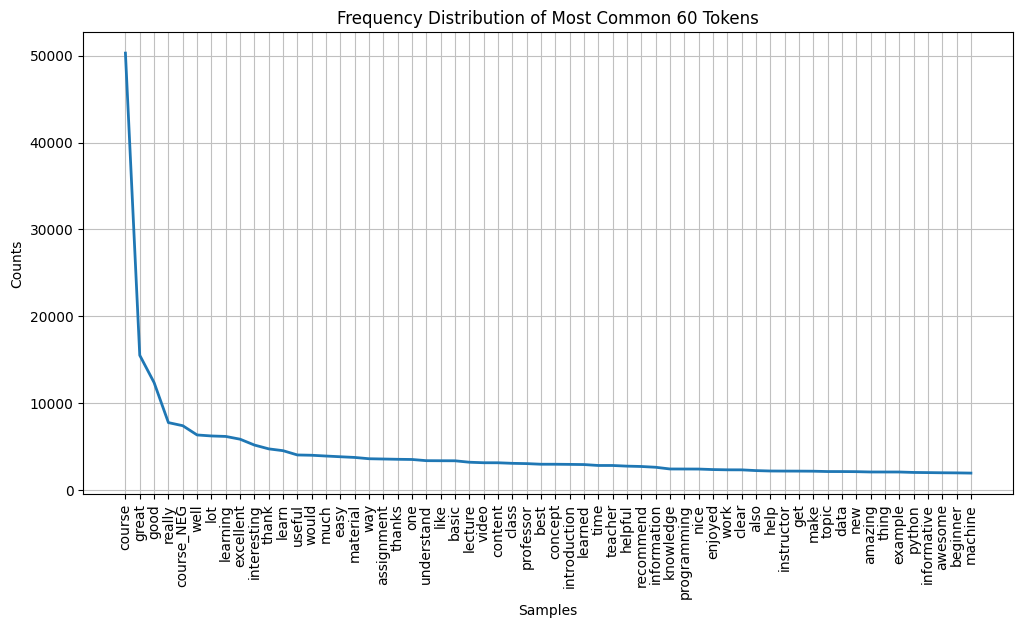

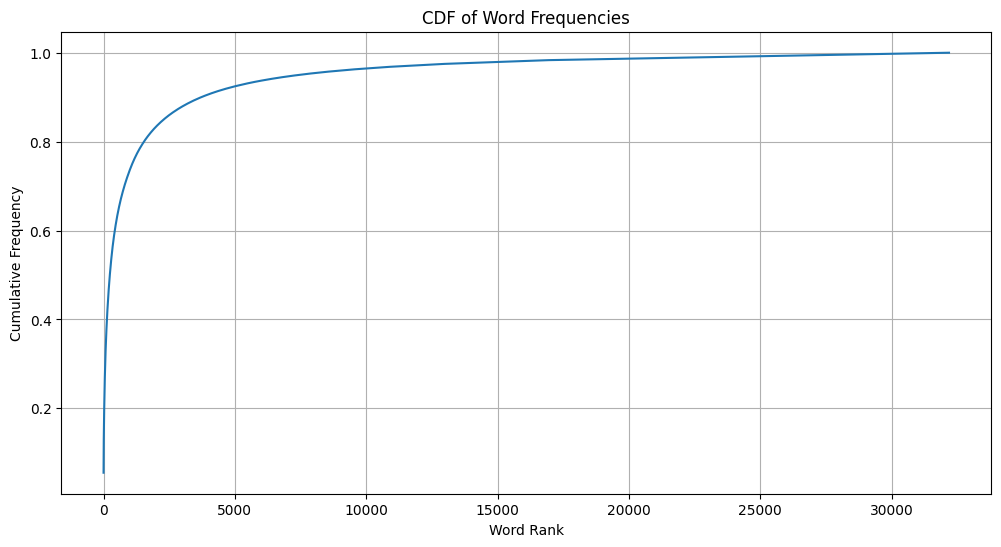

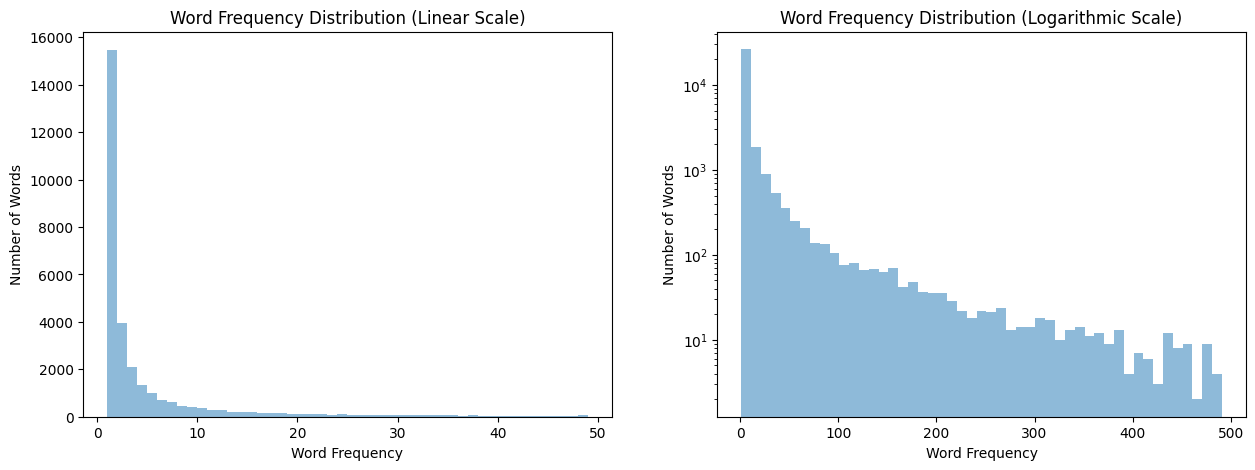

In [ ]:
#make_wordcloud(word_freqs)
plot_word_freq_most_common(x_train, 60) # Zipf's law plot, large number of words have very low frequencies
counts_sorted = plot_word_freq_cdf(word_freqs, max(word_freqs.values()))
plot_word_freq_hist(word_freqs)

Around 90% of the words in the vocabulary occur 700 times or less.

In [ ]:
# PROCESSING-CONSTANTS
min_rank_cutoff = 100
max_rank_cutoff = 12500

# Convert the cutoff values in terms of rank to the actual frequency values
MIN_FREQ = counts_sorted[max_rank_cutoff - 1]  # -1 since 0-based indexing
MAX_FREQ = counts_sorted[min_rank_cutoff - 1]  
print(f"Min Freq: {MIN_FREQ}\nMax Freq: {MAX_FREQ}\n")

Min Freq: 3
Max Freq: 1320



In [ ]:
# Filter vocabulary by removing words with frequency less than a set minimum frequency
vocab = [token for token, freq in word_freqs.items() if MIN_FREQ <= freq <= MAX_FREQ]
vocab_size = len(vocab)
print("Vocabulary size of {} reduced to {}.\n".format(word_freqs_len, vocab_size))
print("Vocabulary (first 50 tokens):\n{}".format(vocab[:50]))
%store vocab
%store vocab_size

Vocabulary size of 32182 reduced to 12656.

Vocabulary (first 50 tokens):
['friendly', 'without', 'background', 'intro', 'developed', 'efficiently', 'provide', 'valuable', 'tool', 'insight', 'education', 'important', 'phenomenon', 'global', 'community', 'enlightening', 'detailed', 'informing', 'whole', 'contains', 'taught', 'know_NEG', 'programming_NEG', 'knew_NEG', 'vast_NEG', 'majority_NEG', 'material_NEG', 'looking_NEG', 'forward_NEG', 'learn_NEG', 'something_NEG', 'substantially_NEG', 'new_NEG', 'opportunity', 'every', 'math', 'jump', 'wonder', 'self', 'watching', 'lesson', 'platform', 'solving', 'using', 'matlab', 'prepared', 'organizer', 'exploring', 'hope', 'enjoy']
Stored 'vocab' (list)
Stored 'vocab_size' (int)


In [ ]:
filtered_word_freq = {word: word_freqs[word] for word in vocab}
calculate_word_statistics(filtered_word_freq)

Mean frequency:  44.30728508217446
Median frequency:  9.0
Max frequency:  1320
Min frequency:  3
Standard deviation:  119.73993956256689
1st quartile:  4.0
3rd quartile:  28.0


In [ ]:
# Create the folder if it doesn't exist
if not os.path.exists(processed_folder_path):
    os.makedirs(processed_folder_path)

file_path = os.path.join(processed_folder_path, vocab_filename)
with open(file_path, 'w') as file:
    file.write('\n'.join(vocab))

### Filter data with vocabulary

In [ ]:
def freq_filter_dataset(docs, filename, vocab):
    filtered_dataset = []
    for doc in docs:
        filtered_text = ' '.join([word for word in doc.split() if word in vocab])
        filtered_dataset.append(filtered_text)

    filtered_dataset = pd.Series(filtered_dataset, index=docs.index)
    
    return filtered_dataset

# Filter dataset based on vocabulary
x_train = freq_filter_dataset(x_train, "x_train", vocab)
x_val = freq_filter_dataset(x_val, "x_val", vocab)
x_test = freq_filter_dataset(x_test, "x_test", vocab)

ValueError: Length of values (1) does not match length of index (20000)

In [ ]:
print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))

Data Distribution:
* train: 68472
* validation: 17118
* test: 21398



In [ ]:
print("x_train - updated:\n", x_train.head(10))

x_train - updated:
 73868                       programming
78926                                  
97646                                  
64107                             clear
61156               learned information
74081                                  
56731     knowledge programming enjo...
20168                                  
25796                                  
103631                                 
dtype: object


In [ ]:
def drop_empty_rows(x, y):
    # Merge x and y datasets and drop empty rows
    merged = pd.concat([x, y], axis=1)
    merged.columns = ['x', 'y']
    
    merged.replace('', np.nan, inplace=True)
    merged.dropna(subset=['x'], inplace=True) # TODO: subset?

    # Re-assign X and Y datasets
    x_filtered = merged['x']
    y_filtered = merged['y']

    return x_filtered, y_filtered

x_train, y_train = drop_empty_rows(x_train, y_train)
x_val, y_val = drop_empty_rows(x_val, y_val)
x_test, y_test = drop_empty_rows(x_test, y_test)

In [ ]:
print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))

Data Distribution:
* train: 33237
* validation: 8371
* test: 10403



In [ ]:
senti_counts = y_train.value_counts()
print_senti_counts(senti_counts)

3 (Positive): 30874 reviews
2 (Neutral): 1356 reviews
1 (Negative): 1007 reviews


# Balance Data

We remove positive reviews that have 3 words or less...

In [ ]:
condition = ~((df['Sentiment'] == 3) & (df['Review'].apply(count_words) < 3))
df = df[condition]

In [ ]:
print(f"Dataset length reduced from {df_raw.shape[0]} to {df.shape[0]}.")

Dataset length reduced from 107018 to 95814.


In [ ]:
# The "strategy" parameter can take a dict, callable, or str as input
# You might need to adjust these parameters according to the distribution of your classes
over_strategy = {1: 5000, 2: 5000} # Over-sample minority classes 10000
under_strategy = {3: 10000} # Under-sample majority classes 40000

# Define pipeline
over = RandomOverSampler(sampling_strategy=over_strategy)
under = RandomUnderSampler(sampling_strategy=under_strategy)
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Applying the balancing pipeline to both x and y datasets
x_balanced, y_balanced = pipeline.fit_resample(pd.DataFrame(x_train), y_train)

# Print out the new class distribution
counter = Counter(y_balanced)
print(counter)

x_train = x_balanced.copy()
y_train = y_balanced.copy()


Counter({3: 10000, 1: 5000, 2: 5000})


In [ ]:
print(x_train.shape, y_train.shape)
print(x_train[:5])

(60000, 1) (60000,)
                               x
0  topic interest however con...
1          really_NEG course_NEG
2  information going fast fee...
3  fast pace make_NEG online_...
4  would recommend_NEG one_NE...


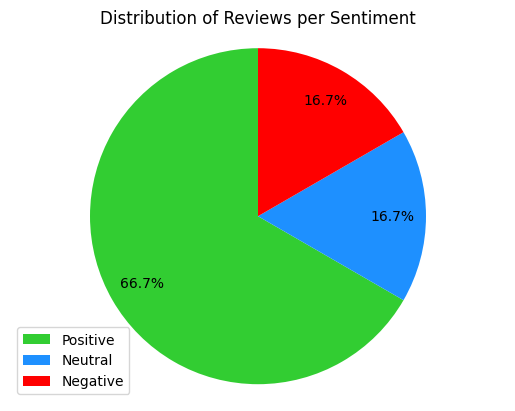

Total word count:  150
Average review length: 150.00


In [ ]:
# Print balanced shape of training data
senti_counts = y_train.value_counts()
plot_senti_counts(senti_counts)

total_word_count = x_train.apply(count_words).sum()
avg_review_len = x_train.apply(count_words).mean()

print("Total word count: ", total_word_count)
print(f"Average review length: {avg_review_len:.2f}")

In [ ]:
def save_data(x, y, filename):
    # Save filtered dataset to a csv file

    # Merge X and Y datasets
    merged_df = pd.concat([x, y], axis=1)
    merged_df.columns = ['x', 'y']
    file_path = os.path.join(input_folder_path, filename)
    merged_df.to_csv(file_path, sep=',', index_label='Id')

save_data(x_train, y_train, "train.csv")
save_data(x_val, y_val, "val.csv")
save_data(x_test, y_test, "test.csv")

## EDA on Training Data

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
Number of one-word lines:  4785
       Word Count  Sentiment
0              15          1
1               2          1
2              13          1
3              16          1
4              28          1
...           ...        ...
59995           5          3
59996          15          3
59997           4          3
59998           5          3
59999           1          3

[60000 rows x 2 columns]


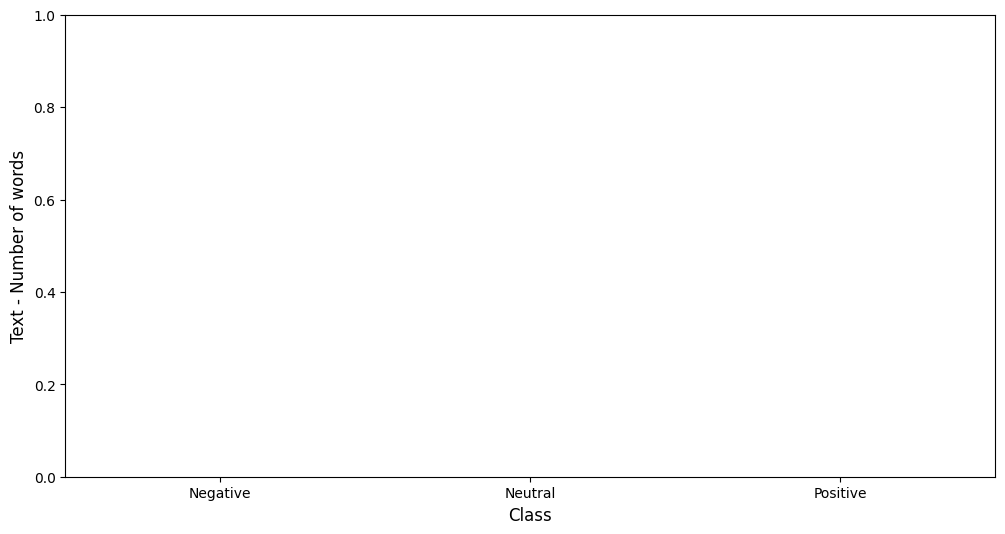

In [ ]:
def plot_freq_class(x, y):
    num_words = x['x'].apply(count_words)
    #print(num_words)
    one_word_lines = num_words[num_words == 1]

    # print the count of one-word lines
    print("Number of one-word lines: ", len(one_word_lines))

    merged_df = pd.DataFrame({'Word Count': num_words, 'Sentiment': y})
    print(merged_df)
    plt.figure(figsize=(12,6))
    sns.boxplot(data=merged_df, x='Sentiment', y='Word Count', order=senti_categories)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Text - Number of words', fontsize=12)
    plt.show()

print(type(x_train), type(y_train))
plot_freq_class(x_train, y_train)